## Nonlinear classification toy example

In the following example, we will consider a synthetic classification problem of a nonlinear nature, so that linear models (such as SVC or logistic regression) do not do very well.

The input data is two-dimensional, so that we can visualize what is going on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')

Before we generate the synthetic dataset, let's just first consider the well-known "exlusive OR problem" that cannot be solved by linear classifiers (`Perceptron`, `LinearSVC`, `LogisticRegression` etc.)

In this dataset, we write down the truth table for an exclusive OR function as a dataset `X`, `Y`. Because of the linear inseparability of this dataset, the linear model cannot learn this training set perfectly.

In [2]:
from sklearn.svm import LinearSVC

X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [0, 0]])
Y = ['no', 'yes', 'yes', 'no']
clf = LinearSVC()
clf.fit(X, Y)
# linear inseparability, so we get less than 100% accuracy
print(accuracy_score(Y, clf.predict(X)))

0.5


However, we *can* learn the function if we apply a *transformation* to the input data. We will just add a third feature that is equal to the product of the first two features. Now we get a perfect classification score, so the classifier has correctly learned this function.

In [3]:
X2 = np.array([[1, 1, 1],
               [1, 0, 0],
               [0, 1, 0],
               [0, 0, 0]])

clf.fit(X2, Y)
print(accuracy_score(Y, clf.predict(X2)))

1.0


### Making the synthetic dataset

Next, we make some data (800 instances) and split it into training and test sets (400 each).

As you can see, the blue dots tend to be situated in an ellipsis-shaped region near the middle, and the red dots outside this region.

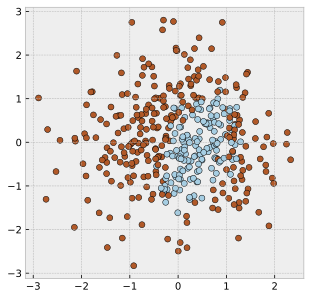

In [4]:
np.random.seed(5)

def f(X):
    X = X.copy()
    X[:,0] -= 0.4
    X[:,1] += 0.2
    return 1.1*X[:,0]**2 + 0.3*X[:,1]**2 - 0.6*X[:,0]*X[:,1]

def make_data():
    N = 800
    X = np.random.normal(size=(N, 2))
    Y = f(X) < 0.5
    X += np.random.normal(size=(N,2), scale=0.2)
    return X, Y

X, Y = make_data()

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=0, test_size=0.5)

plt.figure(figsize=(5,5))
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=Ytrain, cmap='Paired_r', edgecolors='k');

We make a helper function that can plot the dataset and the decision boundary of a classifier.

This code was adapted from an [example](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html) in scikit-learn's documentation.

In [5]:
def plot_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k');

First, let's see how well a majority baseline is doing.

In [6]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(Xtrain, Ytrain)
accuracy_score(Ytest, dummy.predict(Xtest))

0.68

Now we consider a linear classifier (logistic regression). This classifier is completely helpless for this type of data, because of the elliptic shape of the region where the blue dots are situated. Drawing a straight line can't separate the classes. The LR classifier is doing even worse than the dummy baseline.

0.5325

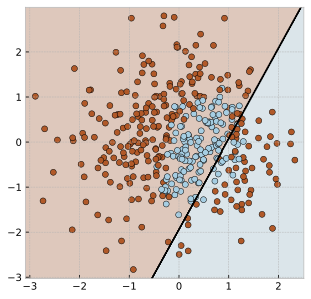

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=10000, solver='lbfgs').fit(Xtrain, Ytrain)

plot_boundary(clf, Xtrain, Ytrain)
accuracy_score(Ytest, clf.predict(Xtest))

### Avoiding linear inseparability by transforming features

One way to make linear classifiers work when we have some data that is not linearly separable is to apply a transformation to the data. In this case, we add an additional feature: $x_3 = x_1^2 + x_2^2$. After adding the additional feature, the logistic regression classifier works better.

We can note that the pipeline *as a whole* is no longer a linear classifier, because it includes the transformation. We can see that the decision boundary is now a circle, not a straight line.

0.8525

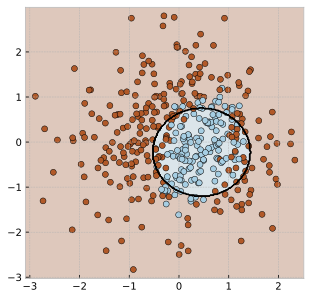

In [8]:
from sklearn.pipeline import make_pipeline

# To add the extra feature to our training data, we make a 
# helper class FeatureExtender that we can put into a pipeline.
class FeatureExtender:

    def fit(self, X, Y=None):
        return self
    
    def transform(self, X, Y=None):
        
        # We compute a new column, by summing the squares of the
        # two other columns.
        new_column = X[:,0]**2 + X[:,1]**2

        # Add the new column to the matrix.
        # (np.c_ is a utility to add a column.)
        return np.c_[X, new_column]

    
pipeline = make_pipeline(
    FeatureExtender(),
    LogisticRegression(solver='lbfgs')
)

pipeline.fit(Xtrain, Ytrain)

plot_boundary(pipeline, Xtrain, Ytrain)

accuracy_score(Ytest, pipeline.predict(Xtest))

Let's also visualize the feature transformation. It's a bit hard to see exactly what is going on in the three-dimensional plot, but the intuition is that by adding a third axis, our data becomes easier to separate for a linear separator. (Blue dots tend to be near the bottom in this case.)

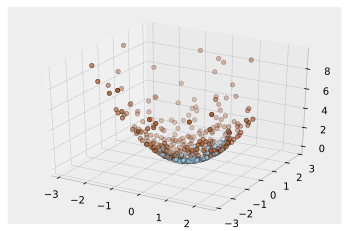

In [9]:
from mpl_toolkits.mplot3d import Axes3D

X3 = FeatureExtender().transform(Xtrain)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X3[:,0], X3[:,1], X3[:,2], c=Ytrain, cmap='Paired_r', edgecolors='k');

###  Training a neural network classifier

In the example above, we defined the feature transformation manually. (Since I knew how I created the data, I had an idea that a transformation of this kind could work.) In general, defining these transformations manually can be impractical. Neural networks instead learn the necessary transformations *automatically*.

In scikit-learn, the neural network classifier is called [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). We create a neural network with a single hidden layer, which contains 10 hidden units. (The default activation function for hidden layers is ReLU; you can add a parameter `activation='tanh'` or `activation='logistic'` optionally.) You can add additional layers as well: for instance, by setting `hidden_layer_sizes=(32, 8)`, you will have two hidden layers with 32 and 8 units, respectively. The option `random_state` is set here to ensure the reproducibility of results.

As you can see, this works better than our manually defined feature transformation. The model captures the blue region fairly successfully.

0.9075

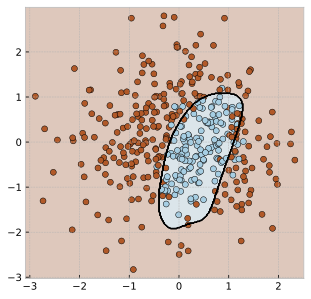

In [14]:
from sklearn.neural_network import MLPClassifier

#clf2 = MLPClassifier(hidden_layer_sizes=10, max_iter=10000, random_state=0)
clf2 = MLPClassifier(hidden_layer_sizes=10, max_iter=10000, random_state=0,activation='tanh')
#clf2 = MLPClassifier(hidden_layer_sizes=(16,16), max_iter=10000, random_state=0, activation='logistic')
clf2.fit(Xtrain, Ytrain)

plot_boundary(clf2, Xtrain, Ytrain)

accuracy_score(Ytest, clf2.predict(Xtest))

### Using our own neural network implementation

We also try out the neural network implementation shown in class. (The code is separate from this notebook, in the file `lecture9.py`.)

This model will use three tanh hidden units. After training, we plot the loss function (evaluated on the training set) for each of the 1000 epochs. In this case, it seems from the graph that we could actually have let the model train for a little bit more.

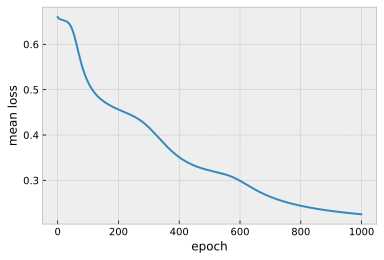

In [16]:
from lecture8 import FeedforwardNN

ffnn = FeedforwardNN(n_hidden=3, n_iter=1000, verbose=False, plot=True, relu=False)
ffnn.fit(Xtrain, Ytrain)

This model is also more or less able to describe the region where the blue dots are situated.

0.91

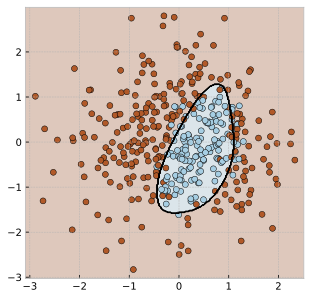

In [17]:
plot_boundary(ffnn, Xtrain, Ytrain)

accuracy_score(Ytest, ffnn.predict(Xtest))

We discussed feature transformation previously, and mentioned that neural networks *automatically* learn a transformation that makes the problem more easy to separate linearly. (After all, the last layer in a neural network is typically a logistic regression classifier.)

Let's take a look at the automatically learned transformation. We first compute the outputs of the hidden layer for each training instance, and then plot this new feature space in a three-dimensional plot. As you can see, the blue dots are concentrated near the lower left corner, which again makes it easier to separate the two classes using a linear separator.

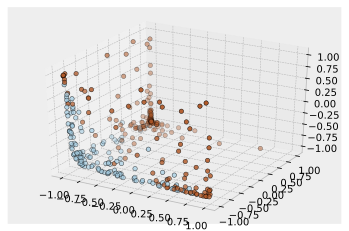

In [18]:
H = ffnn.compute_hidden(Xtrain.dot(ffnn.w1) + ffnn.w1_i)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(H[:,0], H[:,1], H[:,2], c=Ytrain, cmap='Paired_r', edgecolors='k');

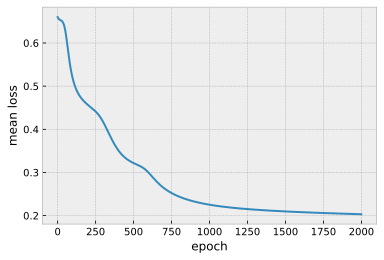

In [19]:
from lecture8 import FeedforwardNN

ffnn1 = FeedforwardNN(n_hidden=3, n_iter=2000, verbose=False, plot=True, relu=False)
ffnn1.fit(Xtrain, Ytrain)